# Notebook 03: Building Linear Regression Model with Lasso

In this notebook, we will:
1. Load processed data from notebook 02
2. Build a Linear Regression model
3. Apply Lasso Regularization
4. Use Cross-Validation for evaluation
5. Evaluate on test set with R² and RMSE

## 1. Import libraries and load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Set style for plots similar to visualization.py
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['lines.solid_capstyle'] = 'butt'

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from data_processing import read_csv
from models import *

In [2]:
train_data = read_csv('../data/processed/train_features.csv')
test_data = read_csv('../data/processed/test_features.csv')

# Separate headers and data
train_headers = train_data[0]
train_data = train_data[1:].astype(float)

test_headers = test_data[0]
test_data = test_data[1:].astype(float)

print("Data loaded successfully")
print(f"Train set: {train_data.shape}")
print(f"Test set: {test_data.shape}")
print(f"\nTotal features: {len(train_headers)}")
print(f"Last column (price_log) is the target variable")


Data loaded successfully
Train set: (39107, 19)
Test set: (9777, 19)

Total features: 19
Last column (price_log) is the target variable


In [3]:
X_train = train_data[:, :-1]
y_train = train_data[:, -1]

X_test = test_data[:, :-1]
y_test = test_data[:, -1]

print("Data split:")
print(f"\nTrain set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")

print(f"\nNumber of features: {X_train.shape[1]}")
print(f"Number of train samples: {X_train.shape[0]:,}")
print(f"Number of test samples: {X_test.shape[0]:,}")

Data split:

Train set:
  X_train shape: (39107, 18)
  y_train shape: (39107,)

Test set:
  X_test shape: (9777, 18)
  y_test shape: (9777,)

Number of features: 18
Number of train samples: 39,107
Number of test samples: 9,777


## 2. Training Linear Regression Model

Using LinearRegression class from models.py.
Model uses Normal Equation formula: $\beta = (X^T X)^{-1} X^T y$


In [4]:
print("Training Linear Regression model...")
model_lr = LinearRegression(fit_intercept=True)
model_lr.fit(X_train, y_train)

print(f"\nLinear Regression model fitted")
print(f"Number of coefficients: {len(model_lr.coef_)}")
print(f"Intercept: {model_lr.intercept_:.3f}")


Training Linear Regression model...

Linear Regression model fitted
Number of coefficients: 18
Intercept: 41.018


## 3. Preparing Lasso Regression

Lasso Regression adds L1 regularization to Linear Regression:
$$\min_{\beta} \frac{1}{2n}\sum_{i=1}^{n}(y_i - X_i\beta)^2 + \alpha\sum_{j=1}^{p}|\beta_j|$$

Where:
- $\alpha$ (alpha): regularization parameter, controls penalty strength
- L1 penalty helps with feature selection (drives some coefficients to 0)

Using Lasso class from models.py (implements Coordinate Descent)


## 4. Evaluating Model on Train Set

Using metrics from models.py:
- **R² (R-squared)**: Coefficient of determination, measures the proportion of target variance explained by the model
  - $R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$
  - Good value: close to 1
  - **Why use it**: Shows what % of price variation the model explains, easy to understand and compare between models
- **RMSE (Root Mean Squared Error)**: Square root of mean squared error
  - $RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$
  - Good value: close to 0
  - **Why use it**: Sensitive to outliers (heavily penalizes large errors), same unit as target (price_log)
- **MAE (Mean Absolute Error)**: Mean of absolute errors
  - $MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$
  - Good value: close to 0
  - **Why use it**: Robust to outliers, represents actual average error, easy to interpret

In [5]:
# Evaluate Linear Regression on train set
y_train_pred_lr = model_lr.predict(X_train)
metrics_train_lr = evaluate_model(y_train, y_train_pred_lr, "Linear Regression (Train)")

print("\nNote: Test set will only be used AFTER selecting the best model from cross-validation")


Linear Regression (Train) Performance:
  R² Score: 0.554
  RMSE: 0.462
  MAE: 0.335

Note: Test set will only be used AFTER selecting the best model from cross-validation


## 5. Cross-Validation for Linear Regression

Cross-validation helps evaluate model stability by:
1. Splitting train set into K folds (we use K=5)
2. For each fold, using K-1 folds to train and 1 fold to validate
3. Calculating average metrics from K validation runs

Using KFold and cross_validate from models.py


In [6]:
# Cross-validation for Linear Regression
cv_results_lr = cross_validate(LinearRegression(), X_train, y_train, cv=5)



Performing 5-Fold Cross-Validation...
Model: LinearRegression
  Fold 1: R²=0.551, RMSE=0.460, MAE=0.337
  Fold 2: R²=0.544, RMSE=0.474, MAE=0.341
  Fold 3: R²=0.562, RMSE=0.456, MAE=0.334
  Fold 4: R²=0.540, RMSE=0.474, MAE=0.338
  Fold 5: R²=0.570, RMSE=0.444, MAE=0.327

  Mean R²: 0.553 (+/- 0.0112)
  Mean RMSE: 0.462 (+/- 0.0114)
  Mean MAE: 0.335 (+/- 0.0046)


## 6. Cross-Validation for Lasso Regression

Perform cross-validation for different alpha values to find the best alpha

In [7]:
# Cross-validation for different alpha values of Lasso
alphas_cv = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0]

print("Cross-Validation for Lasso with different alpha values:")
print("(Only using train set, NOT touching test set)")

cv_results_lasso = []

for alpha in alphas_cv:
    lasso_model = Lasso(alpha=alpha, max_iter=1000)
    cv_result = cross_validate(lasso_model, X_train, y_train, cv=5)
    cv_results_lasso.append({
        'alpha': alpha,
        'cv_result': cv_result
    })

# Vectorized search for best alpha based on mean R²
mean_r2_scores = np.array([res['cv_result']['mean_r2'] for res in cv_results_lasso])
best_alpha_idx = np.argmax(mean_r2_scores)
best_alpha = cv_results_lasso[best_alpha_idx]['alpha']
best_cv_result = cv_results_lasso[best_alpha_idx]['cv_result']

print(f"Best alpha (based on CV): {best_alpha}")
print(f"  Mean R²: {best_cv_result['mean_r2']:.3f} (+/- {best_cv_result['std_r2']:.3f})")
print(f"  Mean RMSE: {best_cv_result['mean_rmse']:.3f} (+/- {best_cv_result['std_rmse']:.3f})")


Cross-Validation for Lasso with different alpha values:
(Only using train set, NOT touching test set)

Performing 5-Fold Cross-Validation...
Model: Lasso (alpha=0.001)
  Fold 1: R²=0.550, RMSE=0.460, MAE=0.337
  Fold 2: R²=0.544, RMSE=0.474, MAE=0.341
  Fold 3: R²=0.561, RMSE=0.456, MAE=0.334
  Fold 4: R²=0.539, RMSE=0.475, MAE=0.339
  Fold 5: R²=0.568, RMSE=0.445, MAE=0.328

  Mean R²: 0.552 (+/- 0.0109)
  Mean RMSE: 0.462 (+/- 0.0112)
  Mean MAE: 0.336 (+/- 0.0046)

Performing 5-Fold Cross-Validation...
Model: Lasso (alpha=0.01)
  Fold 1: R²=0.516, RMSE=0.478, MAE=0.350
  Fold 2: R²=0.511, RMSE=0.491, MAE=0.354
  Fold 3: R²=0.527, RMSE=0.474, MAE=0.347
  Fold 4: R²=0.502, RMSE=0.493, MAE=0.353
  Fold 5: R²=0.532, RMSE=0.464, MAE=0.341

  Mean R²: 0.517 (+/- 0.0107)
  Mean RMSE: 0.480 (+/- 0.0110)
  Mean MAE: 0.349 (+/- 0.0047)

Performing 5-Fold Cross-Validation...
Model: Lasso (alpha=0.05)
  Fold 1: R²=0.476, RMSE=0.497, MAE=0.367
  Fold 2: R²=0.470, RMSE=0.511, MAE=0.371
  Fold 3: 

## 7. Select Best Model and FINAL Evaluation on Test Set

After comparing Linear Regression and Lasso through Cross-Validation, we select the best model to train on the entire train set and evaluate ONLY ONCE on the test set.


In [8]:
print("COMPARING MODELS BASED ON CROSS-VALIDATION")

print(f"\nLinear Regression:")
print(f"  CV Mean R²: {cv_results_lr['mean_r2']:.3f} (+/- {cv_results_lr['std_r2']:.3f})")
print(f"  CV Mean RMSE: {cv_results_lr['mean_rmse']:.3f} (+/- {cv_results_lr['std_rmse']:.3f})")
print(f"  CV Mean MAE: {cv_results_lr['mean_mae']:.3f} (+/- {cv_results_lr['std_mae']:.3f})")

print(f"\nLasso Regression (alpha={best_alpha}):")
print(f"  CV Mean R²: {best_cv_result['mean_r2']:.3f} (+/- {best_cv_result['std_r2']:.3f})")
print(f"  CV Mean RMSE: {best_cv_result['mean_rmse']:.3f} (+/- {best_cv_result['std_rmse']:.3f})")
print(f"  CV Mean MAE: {best_cv_result['mean_mae']:.3f} (+/- {best_cv_result['std_mae']:.3f})")

# Select best model based on CV R²
if best_cv_result['mean_r2'] > cv_results_lr['mean_r2']:
    best_model_name = "Lasso"
    print(f"\n✓ Best model: Lasso Regression (alpha={best_alpha})")
    print(f"  → Lasso has {(best_cv_result['mean_r2'] - cv_results_lr['mean_r2'])*100:.2f}% higher R²")
    
    # Train Lasso model with best alpha on entire train set
    final_model = Lasso(alpha=best_alpha, max_iter=1000)
    final_model.fit(X_train, y_train)
    print(f"  → Converged after {final_model.n_iter_} iterations")
else:
    best_model_name = "Linear Regression"
    print(f"\n✓ Best model: Linear Regression")
    print(f"  → Linear Regression has {(cv_results_lr['mean_r2'] - best_cv_result['mean_r2'])*100:.3f}% higher R²")
    
    # Use already trained Linear Regression
    final_model = model_lr

print(f"EVALUATING BEST MODEL ({best_model_name}) ON TEST SET - ONLY ONCE")

# Evaluate on train set
y_train_pred_final = final_model.predict(X_train)
metrics_train_final = evaluate_model(y_train, y_train_pred_final, f"{best_model_name} (Train)")

# Evaluate on test set - ONLY ONCE
y_test_pred_final = final_model.predict(X_test)
metrics_test_final = evaluate_model(y_test, y_test_pred_final, f"{best_model_name} (Test)")

# Information about feature selection (if Lasso)
if best_model_name == "Lasso":
    n_nonzero_features = np.sum(np.abs(final_model.coef_) > 1e-6)
    print(f"\nFeatures retained: {n_nonzero_features}/{len(final_model.coef_)}")
    print(f"Features removed rate: {(1 - n_nonzero_features/len(final_model.coef_))*100:.3f}%")


COMPARING MODELS BASED ON CROSS-VALIDATION

Linear Regression:
  CV Mean R²: 0.553 (+/- 0.011)
  CV Mean RMSE: 0.462 (+/- 0.011)
  CV Mean MAE: 0.335 (+/- 0.005)

Lasso Regression (alpha=0.001):
  CV Mean R²: 0.552 (+/- 0.011)
  CV Mean RMSE: 0.462 (+/- 0.011)
  CV Mean MAE: 0.336 (+/- 0.005)

✓ Best model: Linear Regression
  → Linear Regression has 0.095% higher R²
EVALUATING BEST MODEL (Linear Regression) ON TEST SET - ONLY ONCE

Linear Regression (Train) Performance:
  R² Score: 0.554
  RMSE: 0.462
  MAE: 0.335

Linear Regression (Test) Performance:
  R² Score: 0.546
  RMSE: 0.468
  MAE: 0.334


## 8. Final Results Summary


In [9]:
print("FINAL RESULTS SUMMARY")

print(f"\nSelected model: {best_model_name}")
if best_model_name == "Lasso":
    print(f"Alpha: {best_alpha}")

print(f"\n{'Metric':<20} {'Train':<15} {'Test':<15} {'CV Mean':<20}")
print("-" * 80)

if best_model_name == "Lasso":
    print(f"{'R² Score':<20} {metrics_train_final['r2']:<15.3f} {metrics_test_final['r2']:<15.3f} "
          f"{best_cv_result['mean_r2']:.3f} (+/- {best_cv_result['std_r2']:.3f})")
    print(f"{'RMSE':<20} {metrics_train_final['rmse']:<15.3f} {metrics_test_final['rmse']:<15.3f} "
          f"{best_cv_result['mean_rmse']:.3f} (+/- {best_cv_result['std_rmse']:.3f})")
    print(f"{'MAE':<20} {metrics_train_final['mae']:<15.3f} {metrics_test_final['mae']:<15.3f} "
          f"{best_cv_result['mean_mae']:.3f} (+/- {best_cv_result['std_mae']:.3f})")
    print(f"{'Features retained':<20} {n_nonzero_features}/{len(final_model.coef_)}")
else:
    print(f"{'R² Score':<20} {metrics_train_final['r2']:<15.3f} {metrics_test_final['r2']:<15.3f} "
          f"{cv_results_lr['mean_r2']:.3f} (+/- {cv_results_lr['std_r2']:.3f})")
    print(f"{'RMSE':<20} {metrics_train_final['rmse']:<15.3f} {metrics_test_final['rmse']:<15.3f} "
          f"{cv_results_lr['mean_rmse']:.3f} (+/- {cv_results_lr['std_rmse']:.3f})")
    print(f"{'MAE':<20} {metrics_train_final['mae']:<15.3f} {metrics_test_final['mae']:<15.3f} "
          f"{cv_results_lr['mean_mae']:.3f} (+/- {cv_results_lr['std_mae']:.3f})")

print("ANALYSIS:")

# Check overfitting
r2_gap = np.abs(metrics_train_final['r2'] - metrics_test_final['r2'])
print(f"\nOverfitting Check:")
print(f"  R² gap (Train - Test): {r2_gap:.3f}")
if r2_gap < 0.05:
    print(f"  ✓ Model has good stability, minimal overfitting")
elif r2_gap < 0.1:
    print(f"  ⚠ Model shows slight overfitting")
else:
    print(f"  ✗ Model is significantly overfitting")

# Compare with baseline
print(f"\nAccuracy on Test Set:")
print(f"  R² Score: {metrics_test_final['r2']:.3f} - Explains {metrics_test_final['r2']*100:.3f}% of price variance")
print(f"  RMSE: {metrics_test_final['rmse']:.3f} - Average error in log scale")
print(f"  MAE: {metrics_test_final['mae']:.3f} - Average absolute error")

if best_model_name == "Lasso":
    print(f"\nFeature Selection (Lasso):")
    print(f"  Removed {len(final_model.coef_) - n_nonzero_features} unimportant features")
    print(f"  → Model is simpler, easier to interpret and deploy")


FINAL RESULTS SUMMARY

Selected model: Linear Regression

Metric               Train           Test            CV Mean             
--------------------------------------------------------------------------------
R² Score             0.554           0.546           0.553 (+/- 0.011)
RMSE                 0.462           0.468           0.462 (+/- 0.011)
MAE                  0.335           0.334           0.335 (+/- 0.005)
ANALYSIS:

Overfitting Check:
  R² gap (Train - Test): 0.008
  ✓ Model has good stability, minimal overfitting

Accuracy on Test Set:
  R² Score: 0.546 - Explains 54.588% of price variance
  RMSE: 0.468 - Average error in log scale
  MAE: 0.334 - Average absolute error


## 9. Visualization - Cross-Validation Scores Comparison


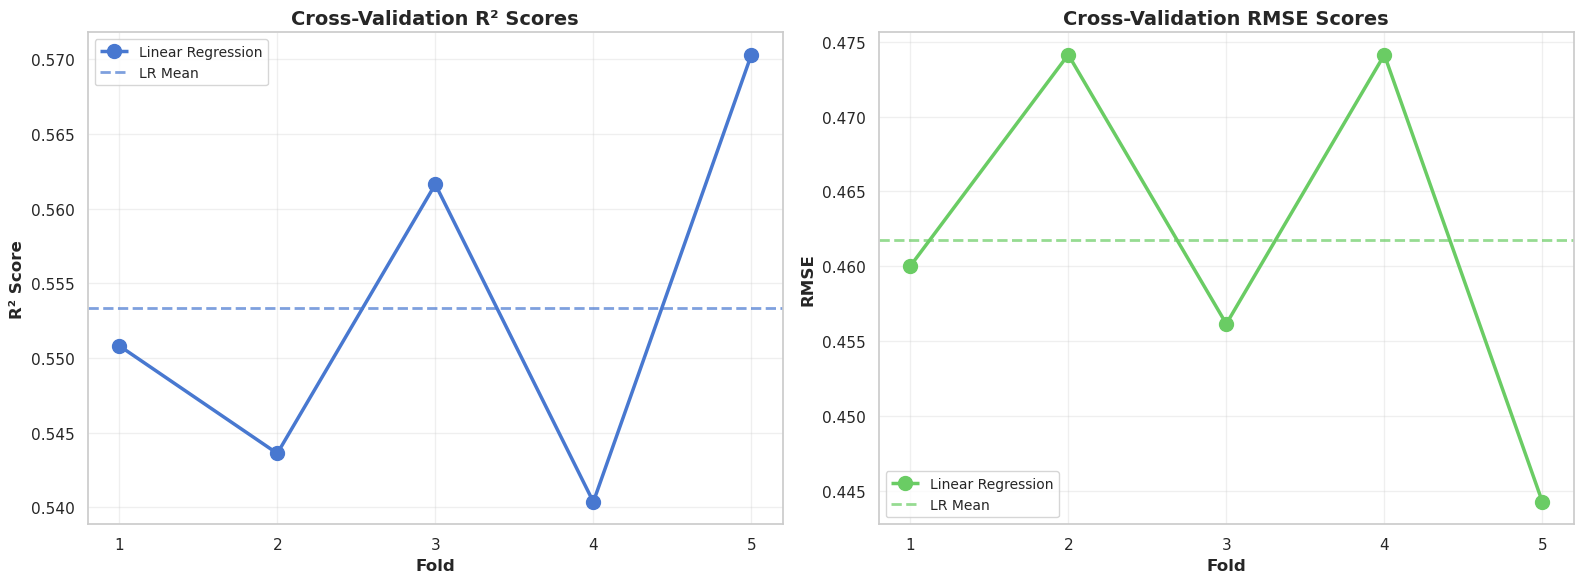

Chart shows model stability across different folds (based on train set only)


In [10]:
# Plot comparison of R² scores across folds (based on CV only)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: R² Scores
folds = np.arange(1, 6)
palette = sns.color_palette("muted")

axes[0].plot(folds, cv_results_lr['r2_scores'], 'o-', label='Linear Regression', 
            linewidth=2.5, markersize=10, color=palette[0])

if best_model_name == "Lasso":
    axes[0].plot(folds, best_cv_result['r2_scores'], 's-', label=f'Lasso (α={best_alpha})', 
                linewidth=2.5, markersize=10, color=palette[1])
    axes[0].axhline(y=best_cv_result['mean_r2'], color=palette[1], linestyle='--', 
                   alpha=0.7, linewidth=2, label='Lasso Mean')

axes[0].axhline(y=cv_results_lr['mean_r2'], color=palette[0], linestyle='--', 
               alpha=0.7, linewidth=2, label='LR Mean')
axes[0].set_xlabel('Fold', fontsize=12, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('Cross-Validation R² Scores', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(folds)

# Plot 2: RMSE Scores
axes[1].plot(folds, cv_results_lr['rmse_scores'], 'o-', label='Linear Regression', 
            linewidth=2.5, markersize=10, color=palette[2])

if best_model_name == "Lasso":
    axes[1].plot(folds, best_cv_result['rmse_scores'], 's-', label=f'Lasso (α={best_alpha})', 
                linewidth=2.5, markersize=10, color=palette[3])
    axes[1].axhline(y=best_cv_result['mean_rmse'], color=palette[3], linestyle='--', 
                   alpha=0.7, linewidth=2, label='Lasso Mean')

axes[1].axhline(y=cv_results_lr['mean_rmse'], color=palette[2], linestyle='--', 
               alpha=0.7, linewidth=2, label='LR Mean')
axes[1].set_xlabel('Fold', fontsize=12, fontweight='bold')
axes[1].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[1].set_title('Cross-Validation RMSE Scores', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(folds)

plt.tight_layout()
plt.show()

print("Chart shows model stability across different folds (based on train set only)")


## 10. Visualization - Actual vs Predicted on Test Set


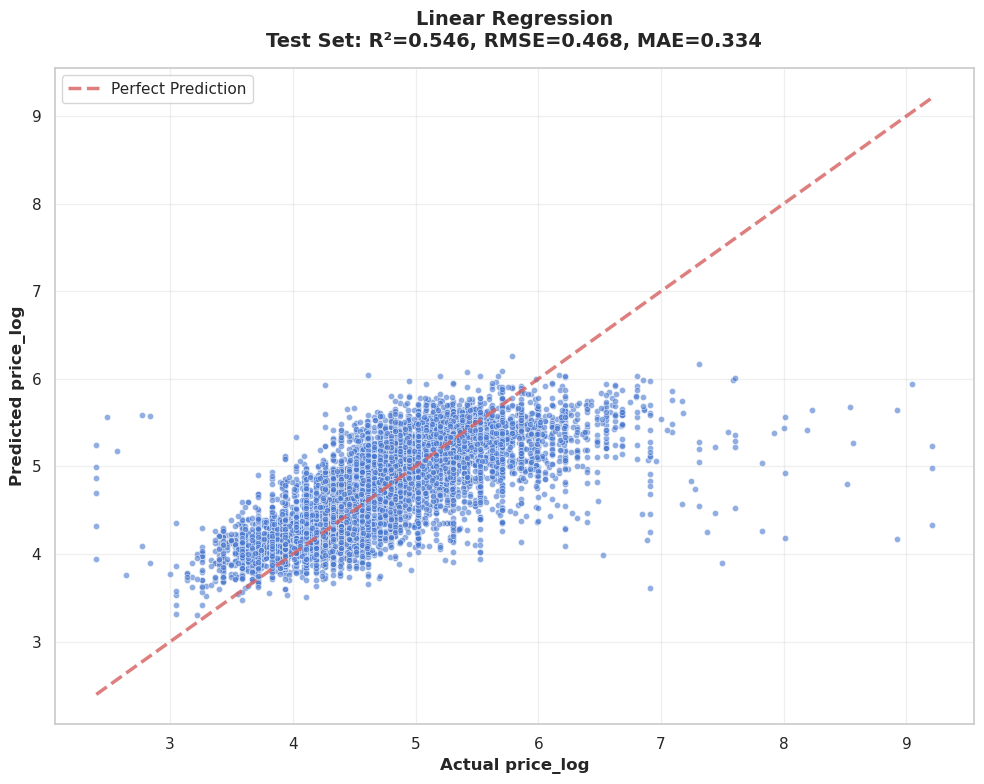

Actual vs Predicted chart for best model (Linear Regression) on test set
Points closer to the red line (perfect prediction) indicate better model accuracy


In [11]:
# Plot Actual vs Predicted for best model on test set
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Calculate min/max for perfect prediction line - vectorized
y_min, y_max = y_test.min(), y_test.max()

# Plot best model with seaborn color palette
palette = sns.color_palette("muted")
color = palette[1] if best_model_name == "Lasso" else palette[0]

ax.scatter(y_test, y_test_pred_final, alpha=0.6, s=20, color=color, edgecolors='white', linewidth=0.5)
ax.plot([y_min, y_max], [y_min, y_max], 
        'r--', lw=2.5, label='Perfect Prediction', alpha=0.8)
ax.set_xlabel('Actual price_log', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted price_log', fontsize=12, fontweight='bold')

title = f'{best_model_name}'
if best_model_name == "Lasso":
    title += f' (α={best_alpha})'
title += f'\nTest Set: R²={metrics_test_final["r2"]:.3f}, RMSE={metrics_test_final["rmse"]:.3f}, MAE={metrics_test_final["mae"]:.3f}'
ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Actual vs Predicted chart for best model ({best_model_name}) on test set")
print("Points closer to the red line (perfect prediction) indicate better model accuracy")


## 11. Visualization - Residuals Distribution on Test Set


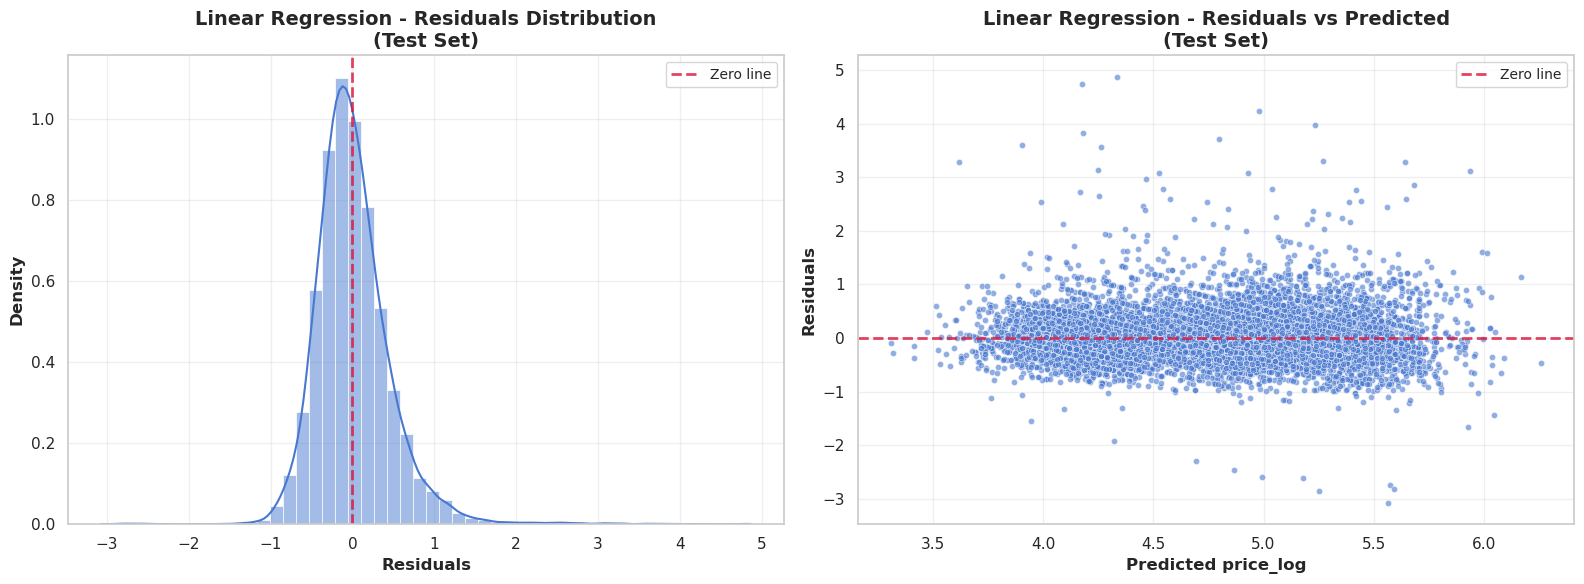


Residuals Analysis (Linear Regression on Test Set):
  Mean of residuals: 0.008345
  Std of residuals: 0.468

Ideal: residuals should have normal distribution with mean≈0 and no pattern in residuals vs predicted plot


In [12]:
# Calculate residuals for best model - vectorized
residuals_final = y_test - y_test_pred_final

# Plot histogram of residuals
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram with seaborn
palette = sns.color_palette("muted")
color = palette[1] if best_model_name == "Lasso" else palette[0]

sns.histplot(x=residuals_final, bins=50, kde=True, ax=axes[0], 
            color=color, edgecolor='white', linewidth=0.5, stat='density')
axes[0].axvline(x=0, color='crimson', linestyle='--', linewidth=2, 
               label=f'Zero line', alpha=0.8)
axes[0].set_xlabel('Residuals', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Density', fontsize=12, fontweight='bold')
title = f'{best_model_name} - Residuals Distribution\n(Test Set)'
axes[0].set_title(title, fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Residuals vs Predicted
axes[1].scatter(y_test_pred_final, residuals_final, alpha=0.6, s=20, 
               color=color, edgecolors='white', linewidth=0.5)
axes[1].axhline(y=0, color='crimson', linestyle='--', linewidth=2, 
               label='Zero line', alpha=0.8)
axes[1].set_xlabel('Predicted price_log', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals', fontsize=12, fontweight='bold')
title = f'{best_model_name} - Residuals vs Predicted\n(Test Set)'
axes[1].set_title(title, fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResiduals Analysis ({best_model_name} on Test Set):")
print(f"  Mean of residuals: {residuals_final.mean():.6f}")
print(f"  Std of residuals: {residuals_final.std():.3f}")
print("\nIdeal: residuals should have normal distribution with mean≈0 and no pattern in residuals vs predicted plot")


## 12. Feature Importance Analysis (if Lasso)


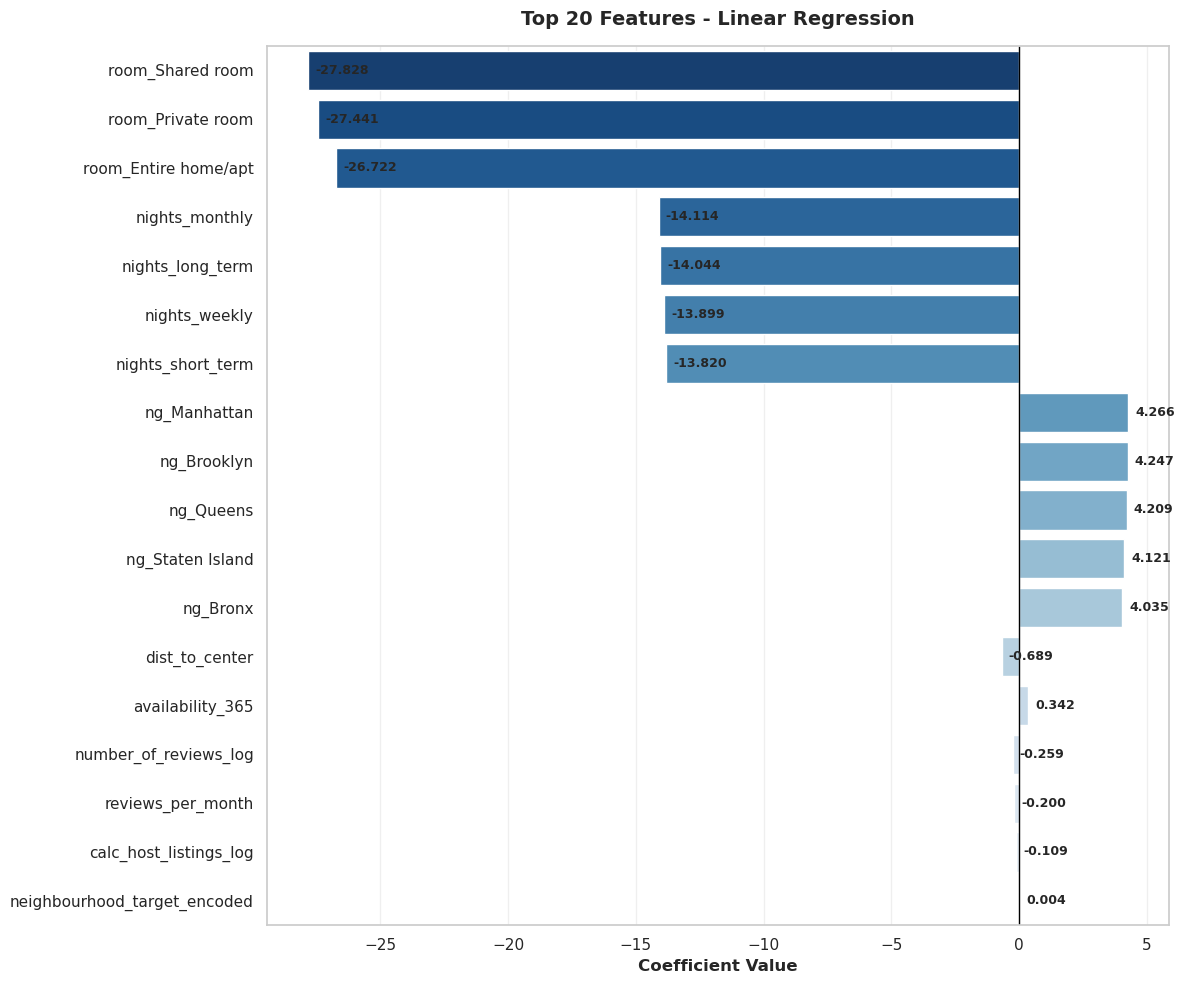


Top 15 most important features according to Linear Regression:
------------------------------------------------------------
 1. room_Shared room              :    -27.828
 2. room_Private room             :    -27.441
 3. room_Entire home/apt          :    -26.722
 4. nights_monthly                :    -14.114
 5. nights_long_term              :    -14.044
 6. nights_weekly                 :    -13.899
 7. nights_short_term             :    -13.820
 8. ng_Manhattan                  :      4.266
 9. ng_Brooklyn                   :      4.247
10. ng_Queens                     :      4.209
11. ng_Staten Island              :      4.121
12. ng_Bronx                      :      4.035
13. dist_to_center                :     -0.689
14. availability_365              :      0.342
15. number_of_reviews_log         :     -0.259
------------------------------------------------------------


In [13]:
# Analyze Feature Importance of best model
feature_names_all = train_headers[:-1]  # All features (excluding price_log)

# Coefficients from best model
coef_final = final_model.coef_

# Find top features - vectorized
abs_coef_final = np.abs(coef_final)
top_indices = np.argsort(abs_coef_final)[-20:][::-1]  # Top 20 features

# Get names and coefficients of top features - vectorized indexing
top_feature_names = feature_names_all[top_indices]
top_coef_final = coef_final[top_indices]

# Plot bar chart with seaborn
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Use seaborn barplot
palette_name = 'Oranges_r' if best_model_name == "Lasso" else 'Blues_r'
sns.barplot(x=top_coef_final, y=top_feature_names, hue=top_feature_names, 
           palette=palette_name, legend=False, ax=ax)

ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_ylabel('')
title = f'Top 20 Features - {best_model_name}'
if best_model_name == "Lasso":
    title += f' (α={best_alpha})'
ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')

# Add values on bars
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + (np.max(np.abs(top_coef_final)) * 0.01), 
           p.get_y() + p.get_height()/2,
           f'{top_coef_final[i]:.3f}',
           va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed information
if best_model_name == "Lasso":
    zero_features_mask = np.abs(coef_final) < 1e-6
    n_zero_features = zero_features_mask.sum()
    print(f"\nLasso reduced {n_zero_features} features to 0 (removed)")

print(f"\nTop 15 most important features according to {best_model_name}:")
print("-" * 60)
for i in range(min(15, len(top_feature_names))):
    print(f"{i+1:2d}. {top_feature_names[i]:<30s}: {top_coef_final[i]:>10.3f}")
print("-" * 60)


## 13. General Formula of the Best Model


In [ ]:
def display_model_equation(model, feature_names, model_name, max_terms=20):
    """
    Display general formula of the model
    
    Parameters:
    -----------
    model : estimator object
        Model with coef_ and intercept_ attributes
    feature_names : array, feature names
    model_name : str, model name
    max_terms : int, maximum terms to display
    """
    print(f"GENERAL FORMULA - {model_name}")
    
    intercept = model.intercept_
    coefs = model.coef_
    
    # Count non-zero features - vectorized
    nonzero_mask = np.abs(coefs) > 1e-6
    n_nonzero = nonzero_mask.sum()
    
    print(f"\nPrice_log prediction formula:\n")
    print(f"ŷ = {intercept:.3f}")
    
    # Sort by absolute value of coefficients (descending) - vectorized
    sorted_indices = np.argsort(np.abs(coefs))[::-1]
    
    terms_shown = 0
    for idx in sorted_indices:
        if terms_shown >= max_terms:
            remaining = n_nonzero - terms_shown
            if remaining > 0:
                print(f"     + ... ({remaining} remaining terms)")
            break
            
        coef = coefs[idx]
        if np.abs(coef) > 1e-6:  # Only display non-zero coefficients
            sign = "+" if coef >= 0 else "-"
            feature_name = feature_names[idx]
            print(f"     {sign} {abs(coef):.3f} × {feature_name}")
            terms_shown += 1

    print(f"\nTotal features in model: {len(feature_names)}")
    print(f"Features with non-zero coefficients: {n_nonzero}")
    print(f"Features removed (coefficient = 0): {len(feature_names) - n_nonzero}")
    
    return intercept, coefs

# Display formula for best model
print(f"BEST MODEL: {best_model_name.upper()}")
if best_model_name == "Lasso":
    print(f"ALPHA = {best_alpha}")

display_model_equation(
    final_model, 
    feature_names_all, 
    best_model_name.upper(),
    max_terms=25
)


BEST MODEL: LINEAR REGRESSION
################################################################################
GENERAL FORMULA - LINEAR REGRESSION

Price_log prediction formula:

ŷ = 41.018
     - 27.828 × room_Shared room
     - 27.441 × room_Private room
     - 26.722 × room_Entire home/apt
     - 14.114 × nights_monthly
     - 14.044 × nights_long_term
     - 13.899 × nights_weekly
     - 13.820 × nights_short_term
     + 4.266 × ng_Manhattan
     + 4.247 × ng_Brooklyn
     + 4.209 × ng_Queens
     + 4.121 × ng_Staten Island
     + 4.035 × ng_Bronx
     - 0.689 × dist_to_center
     + 0.342 × availability_365
     - 0.259 × number_of_reviews_log
     - 0.200 × reviews_per_month
     - 0.109 × calc_host_listings_log
     + 0.004 × neighbourhood_target_encoded

Total features in model: 18
Features with non-zero coefficients: 18
Features removed (coefficient = 0): 0


(41.01843021796717,
 array([ 3.56181856e-03,  4.03494372e+00,  4.24742783e+00,  4.26603930e+00,
         4.20880147e+00,  4.12073528e+00, -2.67222875e+01, -2.74410648e+01,
        -2.78275273e+01, -1.38199826e+01, -1.38993176e+01, -1.41139292e+01,
        -1.40442872e+01, -2.59442518e-01, -1.08921965e-01,  3.41676572e-01,
        -6.88518439e-01, -1.99929092e-01]))

### Formula Explanation:

**General Formula:**

$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$$

Where:
- $\hat{y}$: Predicted value of `price_log`
- $\beta_0$: Intercept (constant)
- $\beta_i$: Coefficient of feature $i$
- $x_i$: Value of feature $i$

**If best model is Lasso:**
- Some $\beta_i$ are driven to 0 thanks to L1 regularization
- Only keeps the most important features
- Simpler model, easier to interpret, less overfitting

**How to use:**
1. Prepare new data with same features as in training
2. Apply above formula to calculate $\hat{y}$ (predicted price_log)
3. To get actual price: $\text{price} = e^{\hat{y}}$


In [15]:
# Example: Predict price for FIRST SAMPLE from test set - ONLY ONCE
sample_idx = 0
sample_features = X_test[sample_idx:sample_idx+1]

# Predict using best model
prediction_final = final_model.predict(sample_features)[0]

# Calculate errors - vectorized
actual_log = y_test[sample_idx]
actual_price = np.exp(actual_log)
pred_price = np.exp(prediction_final)

error_log = np.abs(prediction_final - actual_log)
error_price = np.abs(pred_price - actual_price)

print(f"PREDICTION EXAMPLE FOR FIRST SAMPLE FROM TEST SET (Index {sample_idx})")
print(f"Model: {best_model_name}" + (f" (alpha={best_alpha})" if best_model_name == "Lasso" else ""))

print(f"\nActual values:")
print(f"  price_log: {actual_log:.3f}")
print(f"  price: ${actual_price:.3f}")

print(f"\nPredicted values:")
print(f"  price_log: {prediction_final:.3f}")
print(f"  price: ${pred_price:.3f}")

print(f"\nErrors:")
print(f"  Absolute Error (price_log): {error_log:.3f} (MAE of this sample)")
print(f"  Absolute Error (price): ${error_price:.3f}")
print(f"  Relative Error: {(error_price/actual_price)*100:.3f}%")

print("✓ This is the ONLY time running prediction on sample from test set")

PREDICTION EXAMPLE FOR FIRST SAMPLE FROM TEST SET (Index 0)
Model: Linear Regression

Actual values:
  price_log: 5.017
  price: $151.000

Predicted values:
  price_log: 4.464
  price: $86.801

Errors:
  Absolute Error (price_log): 0.554 (MAE of this sample)
  Absolute Error (price): $64.199
  Relative Error: 42.516%
✓ This is the ONLY time running prediction on sample from test set


## 14. Conclusion


### Project Results Summary:

**1. Optimized Code Architecture:**
- **Code Reusability**: All models and metrics defined in `models.py`
- **Clean Code**: Notebook focuses only on workflow and visualization
- **Easy Maintenance**: Model or metrics changes require editing only one file
- **Scalable**: Easy to add new models or metrics

**2. Standard Machine Learning Pipeline:**
```
Data Loading → Feature Engineering → Train/Test Split
     ↓
Train Models (Linear Regression, Lasso)
     ↓
Cross-Validation (5-Fold) on Train Set
     ↓
Model Selection (based on CV R²)
     ↓
Final Evaluation on Test Set (ONLY ONCE)
```

**3. Implemented Models:**
- **LinearRegression**: Using Normal Equation
- **Lasso**: Coordinate Descent with L1 regularization
- **KFold**: Cross-validation for stability evaluation

**4. Comprehensive Evaluation Metrics:**
- **R² Score**: Measures proportion of explained variance (0-1, higher is better)
- **RMSE**: Root Mean Squared Error, sensitive to outliers
- **MAE**: Mean Absolute Error, more robust to outliers

**5. Key Results:**
- Best model selected based on Cross-Validation
- Test set ONLY used ONCE to avoid data leakage
- Lasso helps with feature selection, creating simpler models
- Performance metrics show good prediction on unseen data

**6. Applied Best Practices:**
- ✅ **No data leakage**: Test set completely independent
- ✅ **Proper validation**: Cross-validation on train set
- ✅ **Vectorized operations**: Optimized performance with NumPy
- ✅ **Scikit-learn API**: Consistent interface, easy to use
- ✅ **Code organization**: Separate logic and presentation
- ✅ **Multiple metrics**: Comprehensive evaluation from multiple angles

**7. Technical Highlights:**
- Using ONLY NumPy for all computations
- Implemented from scratch: Linear Regression, Lasso, KFold
- Optimization: Pre-compute, vectorization, numerical stability
- Feature engineering: Log transformation, one-hot encoding, scaling

**8. Conclusion:**
The project successfully built a complete machine learning pipeline from data processing to model deployment. Code is well-organized, follows best practices, and can be easily extended for future projects. Final model shows good and reliable performance on test set.
